In [1]:
import numpy as np
import pandas as pd
import torch
from permetrics import RegressionMetric

from experiment_runner import (
    ControlConfig,
    ProposedMethodConfig,
    run_comparison_experiments,
)
from svd_based_optimizer import SvdOptimizer
from ols_optimizer import OlsOptimizer
import matplotlib.pyplot as plt
from dimension_estimation import estimate_dimension, OptimalDimensionSelectionMethod, CaoEstimator
from lag_estimation import estimate_tau, OptimalLagSelectionMethod, AmiEstimator

## Loading the dataset

In [2]:
# dataset = pd.read_csv(r".\data\SeriesReport-Seasonally Adjusted Sales - Monthly (Millions of Dollars).csv")
dataset = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/datasets/lynx.csv',
                   index_col=0)
dataset.set_index('time', inplace=True)
dataset.head()

,value
time,
1821,269
1822,321
1823,585
1824,871
1825,1475


In [3]:
dataset.describe()

,value
count,114.000000
mean,1538.017544
std,1585.843914
min,39.000000
25%,348.250000
50%,771.000000
75%,2566.750000
max,6991.000000


In [4]:
# time_series = dataset['Value'].values
time_series = dataset['value'].values
time_series = time_series[np.nonzero(~np.isnan(time_series))]

In [5]:
# time_series_mu = np.mean(time_series)
# time_series_std = np.std(time_series)

# time_series = np.diff(time_series, prepend=time_series[0])
# time_series = (time_series - time_series_mu) / time_series_std
time_series = np.log10(time_series)

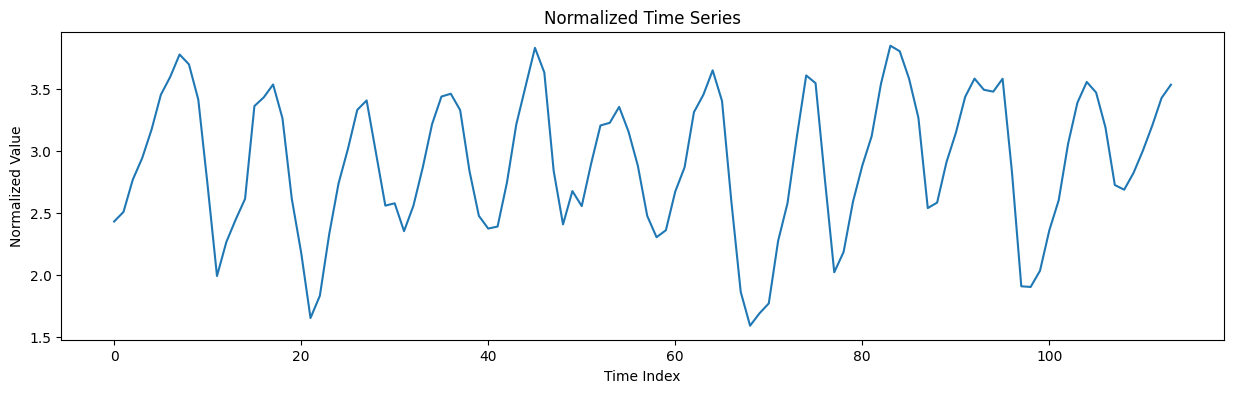

In [6]:
plt.figure(figsize=(15, 4))
plt.plot(time_series)
plt.title('Normalized Time Series')
plt.xlabel('Time Index')
plt.ylabel('Normalized Value')
plt.show()

## Estimating the embedding parameters

In [7]:
tau = estimate_tau(
    time_series,
    estimator=AmiEstimator(
        max_lag=20, optimum_selection_method=OptimalLagSelectionMethod.FIRST_LOC_MIN
    ),
)
print(f"Estimated tau: {tau}")

Estimated tau: 2


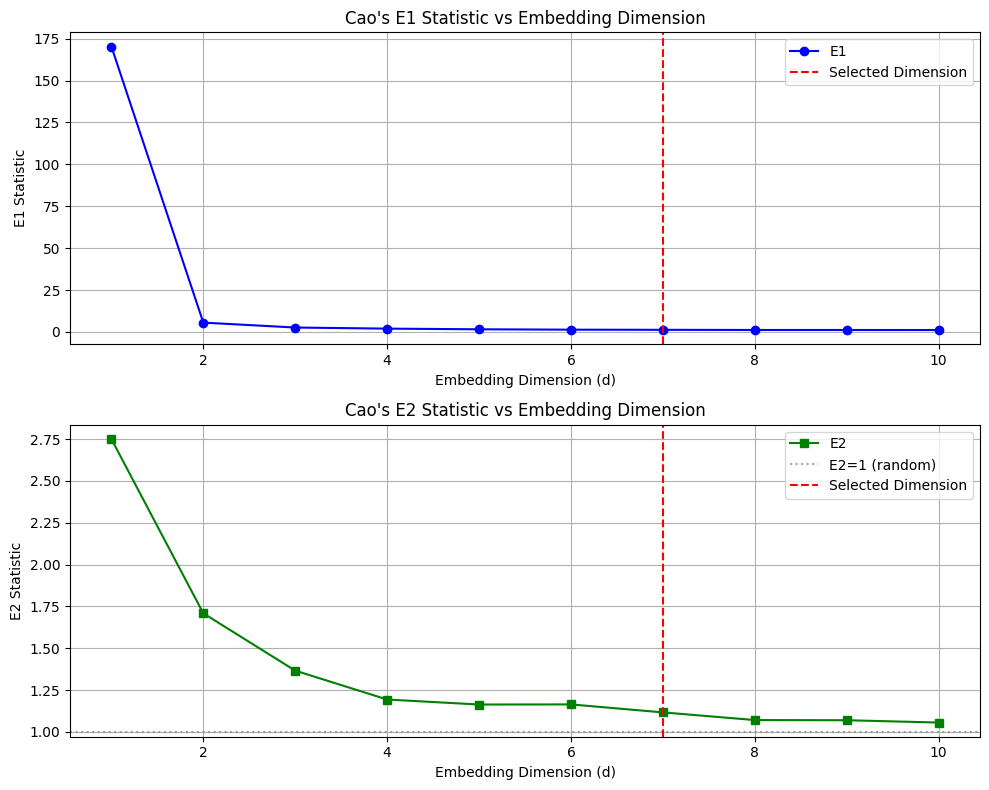

Estimated dimension: 7


In [8]:
dim = estimate_dimension(
    time_series,
    estimator=CaoEstimator(
        delay=tau,
        max_dim=10,
        optimum_selection_method=OptimalDimensionSelectionMethod.E1_E2_COMBINED,
        plot=True,
    ),
)
print(f"Estimated dimension: {dim}")

In [9]:
dim = 4
tau = 1

## Configuring the models

In [17]:
configs = [
    *[
        ProposedMethodConfig(
            approach=approach,
            optimizer=SvdOptimizer(epsilon=eps, alpha=alpha),
            m=m,
            post_tune=post_tune,
            n=dim,
            embedding_tau=tau,
        )
        for dim in [2, 3, 4, 5, 6]
        for tau in [1, 2, 3]
        for m in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
        for alpha in [1e-4, 1e-2, 1e-1, 5e-1, 1, 1.5, 2, 2.5, 5]
        for post_tune in [True, False]
        for eps in [0.01, 0.05, 0.1, 0.2, 0.3]
        for approach in ["pretraining", "no-pretraining"]
    ],
    *[
        ProposedMethodConfig(
            approach=approach,
            optimizer=OlsOptimizer(rho=rho),
            m=max_m,
            n=dim,
            embedding_tau=tau,
            post_tune=post_tune,
        )
        for dim in [2, 3, 4, 5, 6]
        for tau in [1, 2, 3]
        for max_m in [10, 50, 80]
        for rho in [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
        for post_tune in [True, False]
        for approach in ["pretraining", "no-pretraining"]
    ],
]

control_configs = [
    ControlConfig(m=m, n=dim, embedding_tau=tau, lr=lr, sigma_global=True)
    for dim in [2, 3, 4, 5, 6]
    for tau in [1, 2, 3]
    for m in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
    for lr in [1e-3, 1e-2, 5e-2, 1e-1]
]

In [18]:
proposed_results, control_results = run_comparison_experiments(
        time_series,
        configs,
        control_configs,
        train_ratio=0.75,
        device="cuda" if torch.cuda.is_available() else "cpu",
        run_parallel=False,
        show_progress=True,
    )

if not isinstance(proposed_results, list):
    proposed_results = [proposed_results]
if not isinstance(control_results, list):
    control_results = [control_results]

Running Experiments: 100%|██████████| 34380/34380 [26:35<00:00, 21.54experiment/s] 


In [19]:
results_df = pd.DataFrame(
    {
        "Type": [],
        "Name": [],
        "Test R": [],
        "Test R^2": [],
        "Test NRMSE": [],
        "Test SMAPE": [],
        "Test MAAPE": []
    }
)

for res in proposed_results:
    test_metrics = RegressionMetric(
        y_pred=res.test_predictions,
        y_true=res.test_targets,
    )

    new_row = pd.DataFrame(
        {
            "Type": ["Proposed"],
            "Name": [
                f"{res.method_name} (m={res.metadata['total_centers']}, alpha={res.metadata['optimizer_params']['_alpha']}, tuned={res.metadata['post_tuned']})" if res.metadata["optimizer_type"] == "SvdOptimizer" else
                f"{res.method_name} (|C|={res.metadata['selected_centers']}, rho={res.metadata['optimizer_params']['_rho']} tuned={res.metadata['post_tuned']})"
            ],
            "Test R": [test_metrics.pearson_correlation_coefficient()],
            "Test R^2": [test_metrics.R2()],
            "Test NRMSE": [test_metrics.normalized_root_mean_square_error()],
            "Test SMAPE": [test_metrics.symmetric_mean_absolute_percentage_error()],
            "Test MAAPE": [test_metrics.mean_arctangent_absolute_percentage_error()]
        }
    )
    results_df = pd.concat([results_df, new_row], ignore_index=True)

for res in control_results:
    control_test_metrics = RegressionMetric(
        y_pred=res.test_predictions,
        y_true=res.test_targets,
    )

    new_row = pd.DataFrame(
        {
            "Type": ["Control"],
            "Name": [f"Control (m={res.metadata['m_ctrl']})"],
            "Test R": [control_test_metrics.pearson_correlation_coefficient()],
            "Test R^2": [control_test_metrics.R2()],
            "Test NRMSE": [control_test_metrics.normalized_root_mean_square_error()],
            "Test SMAPE": [control_test_metrics.symmetric_mean_absolute_percentage_error()],
            "Test MAAPE": [control_test_metrics.mean_arctangent_absolute_percentage_error()]
        }
    )
    results_df = pd.concat([results_df, new_row], ignore_index=True)

In [20]:
PROPOSED_MODEL_SELECTION_CRITERION = "Test R^2"
PROPOSED_MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE = True

In [21]:
results_df.groupby("Type")[results_df.columns].apply(lambda x: x.sort_values(by=PROPOSED_MODEL_SELECTION_CRITERION, ascending=not PROPOSED_MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE).drop(columns=["Type"]).head(5))

Name    Test R  \
Type                                                                          
Control  33689                                      Control (m=8)  0.910484   
         33665                                      Control (m=2)  0.907093   
         33685                                      Control (m=7)  0.908807   
         33699                                     Control (m=10)  0.898239   
         33673                                      Control (m=4)  0.906411   
Proposed 28046  PROPOSED-pretraining-SvdOptimizer (m=20, alpha...  0.924580   
         28006  PROPOSED-pretraining-SvdOptimizer (m=20, alpha...  0.918736   
         27907  PROPOSED-no-pretraining-SvdOptimizer (m=20, al...  0.919520   
         27889  PROPOSED-no-pretraining-SvdOptimizer (m=15, al...  0.925767   
         27801  PROPOSED-no-pretraining-SvdOptimizer (m=15, al...  0.912524   

                Test R^2  Test NRMSE  Test SMAPE  Test MAAPE  
Type                                                          
Control  33689  0.806344    0.438428    0.029184    0.056488  
         33665  0.803614    0.453668    0.029561    0.057642  
         33685  0.802027    0.441611    0.029543    0.057097  
         33699  0.799314    0.462514    0.030317    0.060142  
         33673  0.797166    0.445184    0.029759    0.057508  
Proposed 28046  0.847683    0.409450    0.025606    0.050553  
         28006  0.836006    0.448922    0.025979    0.052226  
         27907  0.829783    0.444673    0.026679    0.053050  
         27889  0.829756    0.458985    0.026825    0.052789  
         27801  0.828838    0.472894    0.023856    0.048877

In [22]:
print(f"Best proposed model is: {results_df.sort_values(by=["Type", PROPOSED_MODEL_SELECTION_CRITERION], ascending=[False, not PROPOSED_MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE]).head(1)["Name"].values[0]}")

Best proposed model is: PROPOSED-pretraining-SvdOptimizer (m=20, alpha=2.5, tuned=True)


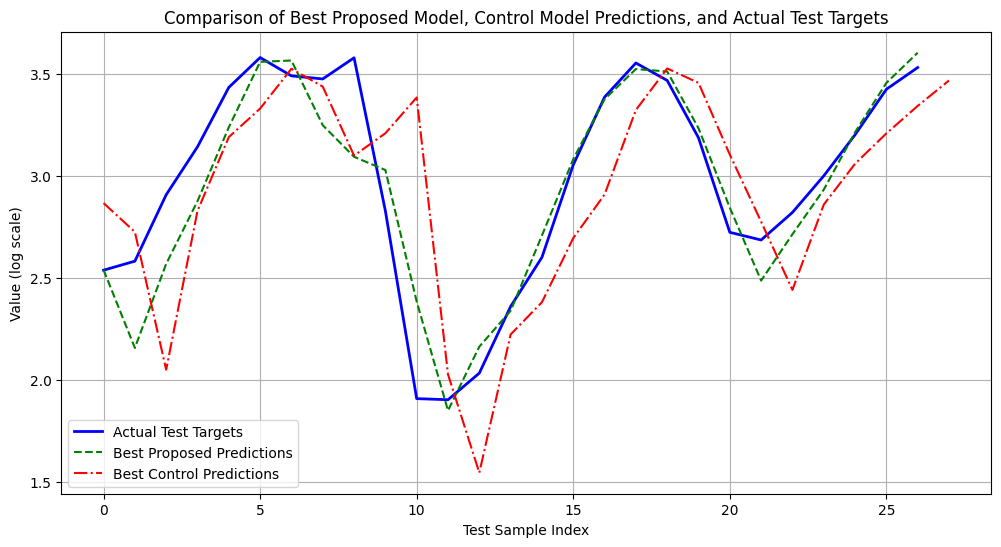

In [23]:
# Find the index of the best proposed model based on lowest Test NRMSE
best_proposed_idx = results_df[results_df["Type"] == "Proposed"][
    PROPOSED_MODEL_SELECTION_CRITERION
].idxmax() if PROPOSED_MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE else results_df[results_df["Type"] == "Proposed"][
    PROPOSED_MODEL_SELECTION_CRITERION
].idxmin()
best_proposed_res = proposed_results[best_proposed_idx]

best_control_idx = results_df[results_df["Type"] == "Control"][
    PROPOSED_MODEL_SELECTION_CRITERION
].idxmax() if PROPOSED_MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE else results_df[results_df["Type"] == "Control"][
    PROPOSED_MODEL_SELECTION_CRITERION
].idxmin()
best_control_res = control_results[best_control_idx - len(proposed_results)]

# Get test targets (actual values for test set)
test_targets = best_proposed_res.test_targets  # Assuming all have the same test_targets

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test_targets, label="Actual Test Targets", color="blue", linewidth=2)
plt.plot(
    best_proposed_res.test_predictions,
    label=f'Best Proposed Predictions',
    color="green",
    linestyle="--",
)
plt.plot(
    best_control_res.test_predictions,
    label=f"Best Control Predictions",
    color="red",
    linestyle="-.",
)
plt.xlabel("Test Sample Index")
plt.ylabel("Value (log scale)")
plt.title(
    "Comparison of Best Proposed Model, Control Model Predictions, and Actual Test Targets"
)
plt.legend()
plt.grid(True)
plt.show()